In [ ]:
!pip install pycm

     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 573kB 26.9MB/s 


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.2MB 27.5MB/s 
     |████████████████████████████████| 3.3MB 48.2MB/s 
     |████████████████████████████████| 870kB 34.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=4c82ad3e82dcb342badd7757948ee8a0f700206a34f416a5b2d5fb48742bf186
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
#Importing all the necessary libraries
from torchvision import models
from pycm import *
from transformers import BertTokenizer, BertModel
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
import pickle
import sys
from glob import glob  
import math
import shutil
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataset
import torch.utils.data.dataloader
import torchvision.transforms as visionTransforms
import PIL.Image as Image
from torchvision.transforms import ToTensor,ToPILImage

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df=pd.read_csv("path_to_add/MIDAS_Task3/Datasets/Task3_Cleaned_Multimodal.csv",index_col=0)  #Please add path_to_add that is required for your local Machine

In [ ]:
df['Image Path']="path_to_add/MIDAS_Task3/"+df['Image Path'] #Please add path_to_add that is required for your local Machine

In [ ]:
#Creating the train(0.8) test(0.1) and validation(0.1) splits
dfTrain,dfVal,dfTest=np.split(df.sample(frac=1, random_state=42), [int(.8 * len(df)), int(.9 * len(df))])
dfTrain=dfTrain.reset_index(drop=True)
dfTest=dfTest.reset_index(drop=True)
dfVal=dfVal.reset_index(drop=True)

In [ ]:
dfTrain

,description,image,product_category_tree,Label,Image Path
0,Specifications of Gee Power Imported Set of 2 ...,"[""http://img5a.flixcart.com/image/goggle/z/z/3...","[""Sports & Fitness >> Other Sports >> Swimming...",21,/content/drive/MyDrive/MIDAS Task/Task3 Images...
1,Nucode Graphic Print Men's Round Neck T-Shirt ...,"[""http://img6a.flixcart.com/image/t-shirt/q/f/...","[""Clothing >> Men's Clothing >> T-Shirts >> Nu...",5,/content/drive/MyDrive/MIDAS Task/Task3 Images...
2,Buy HomeeHub Polyester Multicolor Self Design ...,"[""http://img5a.flixcart.com/image/curtain/b/n/...","[""Home Furnishing >> Curtains & Accessories >>...",14,/content/drive/MyDrive/MIDAS Task/Task3 Images...
3,Gift Island Alloy Necklace - Buy Gift Island A...,"[""http://img6a.flixcart.com/image/necklace-cha...","[""Jewellery >> Necklaces & Chains >> Necklaces""]",16,/content/drive/MyDrive/MIDAS Task/Task3 Images...
4,Flipkart.com: Buy Go Bonjour Stainless Steel 9...,"[""http://img6a.flixcart.com/image/manicure-kit...","[""Beauty and Personal Care >> Body and Skin Ca...",3,/content/drive/MyDrive/MIDAS Task/Task3 Images...
...,...,...,...,...,...
14410,Flipkart.com: Buy Tootpado Art Plastic Punches...,"[""http://img6a.flixcart.com/image/punch-punchi...","[""Pens & Stationery >> Office Supplies >> Punc...",19,/content/drive/MyDrive/MIDAS Task/Task3 Images...
14411,Key Features of IndiWeaves Solid Men's Grey Tr...,"[""http://img5a.flixcart.com/image/track-pant/d...","[""Clothing >> Men's Clothing >> Inner Wear & S...",5,/content/drive/MyDrive/MIDAS Task/Task3 Images...
14412,Fab Fashion Alloy Necklace\n ...,"[""http://img6a.flixcart.com/image/necklace-cha...","[""Jewellery >> Necklaces & Chains >> Necklaces""]",16,/content/drive/MyDrive/MIDAS Task/Task3 Images...
14413,Key Features of THELABELLIFE.com Casual Full S...,"[""http://img5a.flixcart.com/image/top/g/b/x/ac...","[""Clothing >> Women's Clothing >> Western Wear...",5,/content/drive/MyDrive/MIDAS Task/Task3 Images...


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

As visualized in MIDAS_Task3_Preprocessing_Visualization.ipynb there is quite a bit of imbalance in the dataset. We decided to go with the PyTorch WeightedRandomSampler which instead of picking samples randomly in the dataloader will pick it according to weights. And the weight assigned to each class is inversely proportional to the frequency of the class. So the classes with a higher freq are less likely to get sampled, where as classes with a lower frequency are more likely to get sampled

In [ ]:
from torch.utils.data import WeightedRandomSampler
freqLabels=torch.tensor(dfTrain['Label'].value_counts().sort_index(),dtype=torch.double)
weightClass=freqLabels/freqLabels.sum()
weightClass= 1/weightClass
weightClass=(weightClass).tolist()
sampleWeights=[weightClass[i] for i in dfTrain['Label']]
trainSampler=WeightedRandomSampler(sampleWeights,len(dfTrain))

We use a combination of PreTrained BERT, CNNs and Transformer Encoder Blocks for the Text Modality and PreTrained VGG-13(With 3 tunable layers) for the Vision Modality as mentioned in the MIDAS_Task3_Detailed_Analysis.pdf

---


We override the PyTorch Dataset class. FlipkartDataset Class gets the product-desc and the Image Path from the dataframe along with the respective label. 

The encoder_plus function from the Transformer's Library is used to encode the given text seq, truncate the seq if it crosses the max_length arg and pad the seq if it is less than the max_length arg. The encode_plus function is also responsible for providing the attention_masks for each seq which helps BERT identify the tokens which are eligible for attention.

The "vision_transform compose" helps us combine numerous image transformations to make our input-image suitable for Pre-Trained VGG.

In [ ]:
from torch.utils.data import Dataset, DataLoader

class FlipkartDataset(Dataset):

  def __init__(self,dataframe,bertTokenizer,maxLength,vision_transform,device):
    self.data=dataframe
    self.bertTokenizer=bertTokenizer
    self.maxLength=maxLength
    self.vision_transform=vision_transform
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    self.imgPath=str(self.data.iloc[idx,4])
    self.productDescription=str(self.data.iloc[idx,0])
    self.label=self.data.iloc[idx,3]

    self.image=Image.open(self.imgPath).convert('RGB')
    self.image=self.vision_transform(self.image)

    self.encodedInput=self.bertTokenizer.encode_plus(text=self.productDescription,padding='max_length',truncation="longest_first",max_length=self.maxLength,return_tensors='pt',return_attention_mask=True,return_token_type_ids=True).to(device)

    return self.image,self.encodedInput,self.label

In [ ]:
#Composes several transforms together so that our input-image is accepted by PreTrained VGG
preprocess = torchvision.transforms.Compose([
  torchvision.transforms.Resize((224,224)),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

We experimented with a couple of maxLength values(128,256,512). But with 256 and 512, there was a considerable increase in the training time. One other reason to choose maxLength=128 was ~70% of the data has seq length of 0-50. Hampering the training performance just to accommodate the complete seq for 30% of the data seemed like an expensive trade-off. Hence the maxLength was taken as 128

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
flipkartTrainDataset=FlipkartDataset(dataframe=dfTrain,bertTokenizer=tokenizer,maxLength=128,device=device,vision_transform=preprocess)
flipkartTestDataset=FlipkartDataset(dataframe=dfTest,bertTokenizer=tokenizer,maxLength=128,device=device,vision_transform=preprocess)
flipkartValDataset=FlipkartDataset(dataframe=dfVal,bertTokenizer=tokenizer,maxLength=128,device=device,vision_transform=preprocess)

The Weighted Sampler is just used with the Train Set and not the Test and Validation sets because the model should be capable of recognizing any class at test time irrespective of the frequency of the class

In [ ]:
trainLoader=torch.utils.data.DataLoader(flipkartTrainDataset,batch_size=8,sampler=trainSampler)
testLoader=torch.utils.data.DataLoader(flipkartTestDataset,batch_size=8,shuffle=True)
valLoader=torch.utils.data.DataLoader(flipkartValDataset,batch_size=8,shuffle=True)

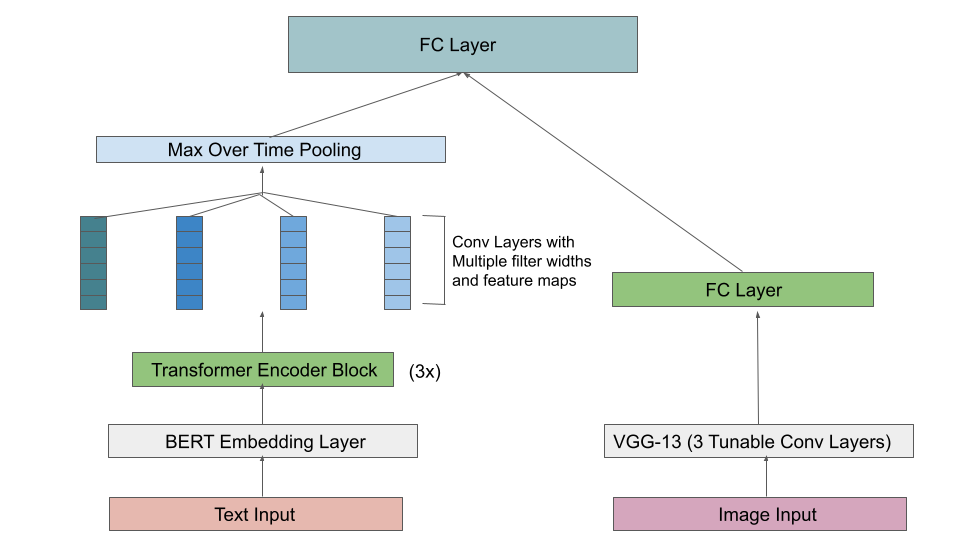

The above diagram provides a visual representation of the architecture. The intution behind each part of the architecture is as follows:

*   **Pre Trained BERT**: BERT was used to get high quality word embeddings which are extremely critical to achieve high performance.
*   **Transformer Encoder Blocks**: The intution behind using encoder blocks was to get more dataset specific/personalized embeddings.
*   **KimCNN**: The conv layers with different feature widths help the network look at different features of the tensor, leading to significant increase in the performance.
*   **VGG-13**: The PreTrained VGG-13 was trained on ImageNet none of which had e-commerce data. Therefore to customize this for our data, the last 3 conv layers were tunable


In [ ]:
class MultiModalNetwork(nn.Module):
  def __init__(self,preTrainedBert,preTrainedVGG,textInChannels=1,embeddingDimension=768,numHeads=8,numEncoderLayers=3,numClasses=27):
    super(MultiModalNetwork,self).__init__()

    self.textInChannels=textInChannels
    self.embDim=embeddingDimension
    self.numHeads=numHeads
    self.numEncoderLayers=numEncoderLayers
    self.numClasses=numClasses

    self.bert=self.freezeBert(preTrainedBert)

    self.vgg13=self.freezeVGG(preTrainedVGG)

    self.encoderLayer=nn.TransformerEncoderLayer(d_model=self.embDim,nhead=self.numHeads)
    self.encoderBlock=nn.TransformerEncoder(self.encoderLayer,num_layers=self.numEncoderLayers)
    self.kimConv0=nn.Conv2d(in_channels=self.textInChannels,out_channels=100,kernel_size=(2,self.embDim))
    self.kimConv1=nn.Conv2d(in_channels=self.textInChannels,out_channels=100,kernel_size=(3,self.embDim))
    self.kimConv2=nn.Conv2d(in_channels=self.textInChannels,out_channels=100,kernel_size=(4,self.embDim))
    self.kimConv3=nn.Conv2d(in_channels=self.textInChannels,out_channels=100,kernel_size=(5,self.embDim))
    self.dropoutLayer=nn.Dropout(p=0.5)
    self.fc=nn.Linear(800,self.numClasses)

  def forward(self,textInput,imgInput):

    bertOutput=self.bert(input_ids=textInput['input_ids'].squeeze(dim=1),attention_mask=textInput['attention_mask'].squeeze(dim=1),token_type_ids=textInput['token_type_ids'].squeeze(dim=1)).last_hidden_state

    encoderInput=bertOutput.transpose(1,0) 
    encoderOutput=self.encoderBlock(encoderInput)
    encoderOutput=encoderOutput.transpose(1,0)
    
    kimInput=encoderOutput.unsqueeze(1)
    
    conv0_Output=F.relu(self.kimConv0(kimInput)).squeeze(3)
    conv1_Output=F.relu(self.kimConv1(kimInput)).squeeze(3)
    conv2_Output=F.relu(self.kimConv2(kimInput)).squeeze(3)
    conv3_Output=F.relu(self.kimConv3(kimInput)).squeeze(3)
    
    conv0_Output=F.max_pool1d(conv0_Output,conv0_Output.size(2))
    conv1_Output=F.max_pool1d(conv1_Output,conv1_Output.size(2))
    conv2_Output=F.max_pool1d(conv2_Output,conv2_Output.size(2))
    conv3_Output=F.max_pool1d(conv3_Output,conv3_Output.size(2))

    kimOutput=torch.cat((conv0_Output.squeeze(dim=2),conv1_Output.squeeze(dim=2),conv2_Output.squeeze(dim=2),conv3_Output.squeeze(dim=2)),dim=1)

    imgOutput=self.vgg13(imgInput)

    combinedOutput=torch.cat((kimOutput,imgOutput),1)

    output=self.fc(self.dropoutLayer(combinedOutput))

    return output

  def freezeVGG(self,originalPreTrainedVGG):
    count=0
    for param in originalPreTrainedVGG.features.parameters():
      if count<14:
        param.requires_grad=False
      count=count+1
    features=list(originalPreTrainedVGG.classifier.children())[:-3]
    features[3]=nn.Linear(4096,400)
    originalPreTrainedVGG.classifier = nn.Sequential(*features)
    return originalPreTrainedVGG

  def freezeBert(self,model):
    for params in model.parameters():
      params.requires_grad=False
    return model

Adam was used as an optimizer with a learning rate of 10^-4 and Cross Entropy Loss was used as the loss function.

In [ ]:
bertModel = BertModel.from_pretrained('bert-base-uncased')
vggModel=models.vgg13(pretrained=True)
multiModalModel=MultiModalNetwork(preTrainedBert=bertModel,preTrainedVGG=vggModel)
multiModalModel.to(device)
softmaxLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(multiModalModel.parameters(), lr=0.0001)

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.cache/torch/hub/checkpoints/vgg13-c768596a.pth


In [ ]:
def Average(lst): 
    return sum(lst) / len(lst) 

def train_model(model,epochs):

  trainBatchCount=0
  testBatchCount=0

  avgTrainAcc=[]
  avgValidAcc=[]
  trainAcc=[]
  validAcc=[]
  trainLosses=[]
  validLosses=[]
  avgTrainLoss=[]
  avgValidLoss=[]


  for i in range(epochs):

    print("Epoch:",i)

    model.train()
    print("Training.....")
    for batch_idx,(imgData,textData,targets) in enumerate(trainLoader):

      trainBatchCount=trainBatchCount+1

      imgData=imgData.to(device)
      targets=targets.to(device)

      optimizer.zero_grad()

      scores=model(textInput=textData,imgInput=imgData)
       
      loss=softmaxLoss(scores,targets)

      loss.backward()

      optimizer.step()

      trainLosses.append(float(loss))

      
      correct=0
      total=0
      total=len(targets)


      predictions=torch.argmax(scores,dim=1)
      correct = (predictions==targets).sum()
      acc=float((correct/float(total))*100)

      trainAcc.append(acc)

      if ((trainBatchCount%200)==0):

        print("Targets:-",targets)
        print("Predictions:-",predictions)

        print('Loss: {}  Accuracy: {} %'.format(loss.data, acc))

    model.eval()
    print("Validating.....")
    for imgData,textData,targets in valLoader:

      testBatchCount=testBatchCount+1

      targets=targets.to(device=device)
      imgData=imgData.to(device)

      scores=model(textInput=textData,imgInput=imgData)

      loss=softmaxLoss(scores,targets)

      validLosses.append(float(loss))

      testCorrect=0
      testTotal=0

      _,predictions=scores.max(1)

      testCorrect = (predictions==targets).sum()
      testTotal=predictions.size(0)

      testAcc=float((testCorrect/float(testTotal))*100)

      validAcc.append(testAcc)

      if ((testBatchCount%200)==0):

        print('Loss: {}  Accuracy: {} %'.format(float(loss), testAcc))
    

    trainLoss=Average(trainLosses)
    validLoss=Average(validLosses)
    avgTrainLoss.append(trainLoss)
    avgValidLoss.append(validLoss)
    tempTrainAcc=Average(trainAcc)
    tempTestAcc=Average(validAcc)
    avgTrainAcc.append(tempTrainAcc)
    avgValidAcc.append(tempTestAcc)

    print("Epoch Number:-",i,"  ","Training Loss:-"," ",trainLoss,"Validation Loss:-"," ",validLoss,"Training Acc:-"," ",tempTrainAcc,"Validation Acc:-"," ",tempTestAcc)

    trainAcc=[]
    ValidAcc=[]
    trainLosses=[]
    validLosses=[]

  return model,avgTrainLoss,avgValidLoss,avgTrainAcc,avgValidAcc

The model was trained for 10 epochs

In [ ]:
multiModalModel,avgTrainLoss,avgValidLoss,avgTrainAcc,avgValidAcc=train_model(multiModalModel,10)

Epoch: 0
Training.....
Targets:- tensor([22,  5, 11,  1,  7,  4,  2,  2], device='cuda:0')
Predictions:- tensor([22,  5, 11, 23,  7,  4,  2,  2], device='cuda:0')
Loss: 0.49779000878334045  Accuracy: 87.5 %
Targets:- tensor([ 7, 21, 13, 14,  3,  8, 14,  6], device='cuda:0')
Predictions:- tensor([ 7,  5, 13, 14,  3,  8, 14,  6], device='cuda:0')
Loss: 0.29639166593551636  Accuracy: 87.5 %
Targets:- tensor([ 0, 11, 19,  6, 21, 19,  7, 20], device='cuda:0')
Predictions:- tensor([ 0, 11, 19,  6, 18, 19,  7, 20], device='cuda:0')
Loss: 0.4356541335582733  Accuracy: 87.5 %
Targets:- tensor([14, 19, 13, 23,  3,  6,  2, 17], device='cuda:0')
Predictions:- tensor([ 8,  6, 13, 16,  3,  6,  2, 17], device='cuda:0')
Loss: 1.340337872505188  Accuracy: 62.5 %
Targets:- tensor([ 2, 17, 13, 19, 25, 24,  8,  7], device='cuda:0')
Predictions:- tensor([ 2, 17, 13, 19, 25, 24,  8,  7], device='cuda:0')
Loss: 0.04982458055019379  Accuracy: 100.0 %


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Targets:- tensor([ 6, 17, 23, 21, 25, 25, 12, 14], device='cuda:0')
Predictions:- tensor([ 6, 17, 23, 21, 25, 25, 12, 14], device='cuda:0')
Loss: 0.16787782311439514  Accuracy: 100.0 %
Targets:- tensor([11,  5, 14, 23,  6, 14, 23, 10], device='cuda:0')
Predictions:- tensor([11,  5, 12, 23,  6, 14, 23, 10], device='cuda:0')
Loss: 0.30477216839790344  Accuracy: 87.5 %


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (90608000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Targets:- tensor([25,  7, 18, 15,  4,  7, 12,  2], device='cuda:0')
Predictions:- tensor([25,  7, 18, 15,  4,  7, 24,  2], device='cuda:0')
Loss: 0.2944600284099579  Accuracy: 87.5 %
Targets:- tensor([ 2, 14,  1, 14, 20, 20, 24, 24], device='cuda:0')
Predictions:- tensor([ 2, 14,  1, 14, 20, 20, 24, 17], device='cuda:0')
Loss: 0.533109188079834  Accuracy: 87.5 %
Validating.....
Loss: 0.013828757219016552  Accuracy: 100.0 %
Epoch Number:- 0    Training Loss:-   0.45294034107852527 Validation Loss:-   0.26097242658502223 Training Acc:-   87.82503567948591 Validation Acc:-   93.69469026548673
Epoch: 1
Training.....
Targets:- tensor([25, 20, 24, 18,  4, 21, 18, 19], device='cuda:0')
Predictions:- tensor([25, 20, 24, 18,  4, 21, 18, 19], device='cuda:0')
Loss: 0.05514877289533615  Accuracy: 100.0 %
Targets:- tensor([10, 20, 16, 16, 18,  0, 10,  0], device='cuda:0')
Predictions:- tensor([10, 20, 16, 16, 18,  0, 10,  0], device='cuda:0')
Loss: 0.0009306879946961999  Accuracy: 100.0 %
Targets:

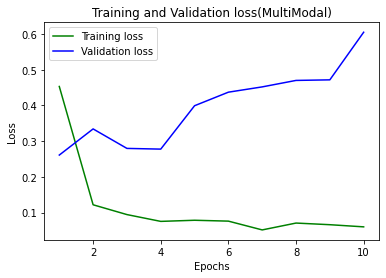

In [ ]:
#Loss Behaviour against Epochs
loss_train = avgTrainLoss
loss_val = avgValidLoss
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss(MultiModal)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

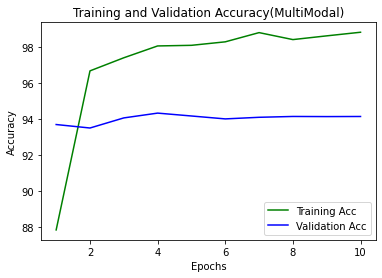

In [ ]:
#Accuracy Behaviour against Epochs
acc_train = avgTrainAcc
acc_val = avgValidAcc
epochs = range(1,11)
plt.plot(epochs, acc_train, 'g', label='Training Acc')
plt.plot(epochs, acc_val, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy(MultiModal)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def checkClassificationMetrics(loader,model):

  completeTargets=[]
  completePreds=[]

  correct=0
  total=0
  model.eval()

  with torch.no_grad():
    for imgData,textData,targets in loader:

      targets=targets.to(device=device)
      imgData=imgData.to(device)

      scores=model(textInput=textData,imgInput=imgData)
      
      _,predictions=scores.max(1)

      targets=targets.tolist()
      predictions=predictions.tolist()

      completeTargets.append(targets)
      completePreds.append(predictions)

    completeTargetsFlattened=[item for sublist in completeTargets for item in sublist]
    completePredsFlattened=[item for sublist in completePreds for item in sublist]

    cm = ConfusionMatrix(actual_vector=completeTargetsFlattened, predict_vector=completePredsFlattened)
    return cm

In [ ]:
CM=checkClassificationMetrics(testLoader,multiModalModel)

A number of evaluation metrics were considered. The pycm module was utilized to calculate these metrics

In [ ]:
print("Evaluation Metrics:-")
print("Accuracy:-", CM.Overall_ACC*100)
print("F1 Micro:-", CM.F1_Micro)
print("Kappa:-",CM.Kappa)
print("MCC:-",CM.Overall_MCC)

Evaluation Metrics:-
Accuracy:- 94.45061043285239
F1 Micro:- 0.9445061043285239
Kappa:- 0.9358508378905819
MCC:- 0.9360491144924689


In [ ]:
torch.save(multiModalModel.state_dict(),"path_to_add/MIDAS_Task3/Models/MultiModalModel.pt")  #Please add path_to_add that is required for your local Machine